In [1]:
import torch.nn as nn
import torch
import os
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2
        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4
        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8
        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16
        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)#no padding,fcn ks =224/32
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()
        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)
        
        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8
       
        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)
        
        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)

        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h


In [2]:
model = FCN8s()

In [3]:
pretrained_model =os.path.expanduser('~/hctech/fcn8s_from_caffe.pth')
model.load_state_dict(torch.load(pretrained_model))
model.eval()

FCN8s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2

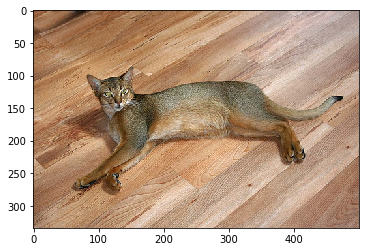

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
input_image = Image.open("./2010_005115.jpg")
def transform(img):
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = np.array(img, dtype=np.uint8)
    img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img
img = transform(input_image)
plt.imshow(input_image)
plt.show()

In [5]:
from torchvision import transforms
input_batch = img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    score = model(input_batch)
lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
print(score.shape)

torch.Size([1, 21, 334, 500])


In [6]:
def untransform(img):
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    img += mean_bgr
    img = img.astype(np.uint8)
    img = img[:, :, ::-1]
    return img
img = untransform(img)

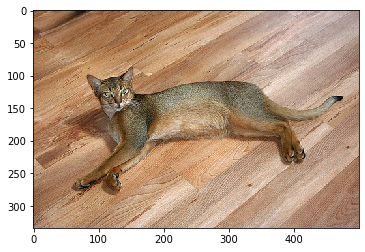

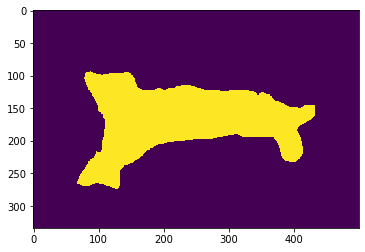

In [7]:
plt.imshow(img)
plt.show()
plt.imshow(lbl_pred[0])
plt.show()